<a id="Subcluster_TNK"></a>
## Sub-cluster T/NK cells

- [1. Load raw data](#loadT)
- [2. Subclustering 1 - remove doublets](#cluster_T1)
- [3. Subclustering 2 - classify cell types](#cluster_T2)
- [4. Output results figures](#figuresT)

In [1]:
import os
adir = '../../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
results_dir = '../../../../../results'

gcs = False
abase = os.path.join(adir, project_name)
abase

'../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../../Code')
from utils import save_adata, read_adata, subcluster_iteration

import palettable
from IPython.display import display

from joblib import parallel_backend

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


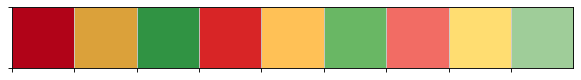

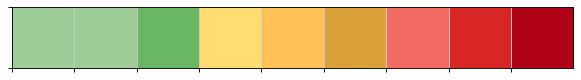

In [5]:
dpi_colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(dpi_colors)
sns.palplot(dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]

dpi_colors2 = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
dpimap2 = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors2[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap2['0'] = palettable.tableau.TableauMedium_10.hex_colors[-1]

<a id="loadT"></a>

## Load raw data and previous clustering results

In [6]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))

print(annot_file)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMB.h5ad


In [7]:
adata_annot = read_adata(annot_file, gcs=gcs)

Only considering the two last: ['.SubclusterMB', '.h5ad'].
Only considering the two last: ['.SubclusterMB', '.h5ad'].


In [8]:
adata_annot

AnnData object with n_obs × n_vars = 61819 × 16853 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dis

In [9]:
adata_annot.obs['leiden_lab_group_2'].value_counts()

Th             19306
B              15278
Tc             11002
Mono/DC         8520
Neut            5974
NK              1191
Platelet         308
Plasmablast      240
Name: leiden_lab_group_2, dtype: int64

In [10]:
adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group_2'].isin(['Th', 'Tc', 'NK']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

sc.pp.normalize_per_cell(adata_raw_full, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw_full)

adata_raw.raw = adata_raw_full

filtered out 2264 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


<a id="cluster_T1"></a>
## Iterative subclustering 1 - removes doublets

In [11]:
genestoplot = ['CD3D', 'IL7R', 'GZMB', 'MS4A1', 'IGKC', 'MKI67', 'PPBP', 'HBB', 'frz_status']

filtered out 2888 genes that are detectedin less than 31 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)


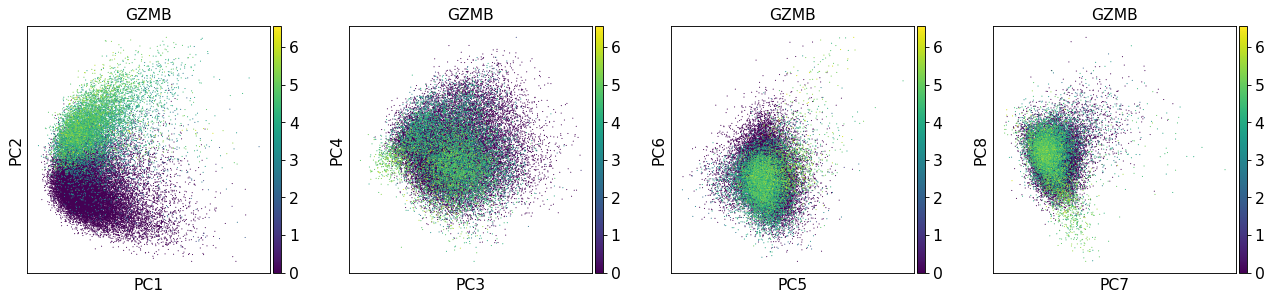

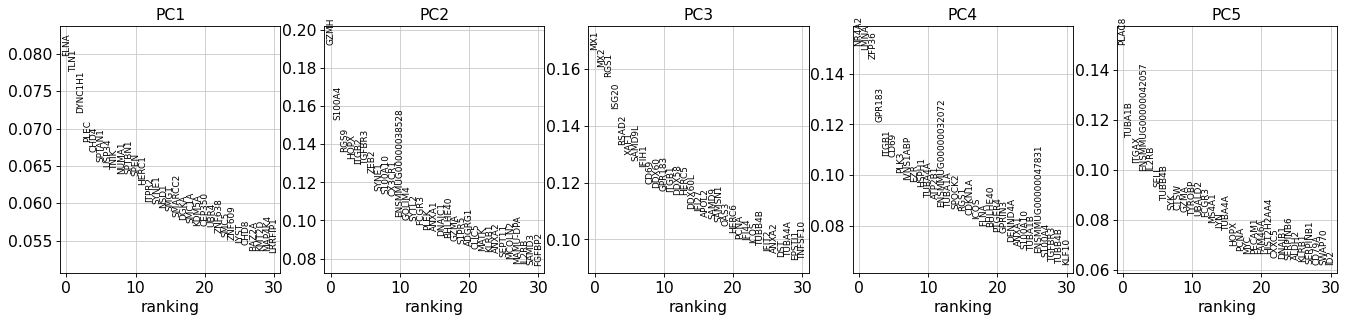

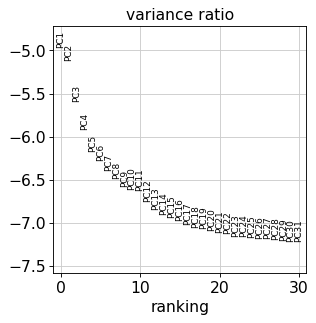

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:51)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:29)


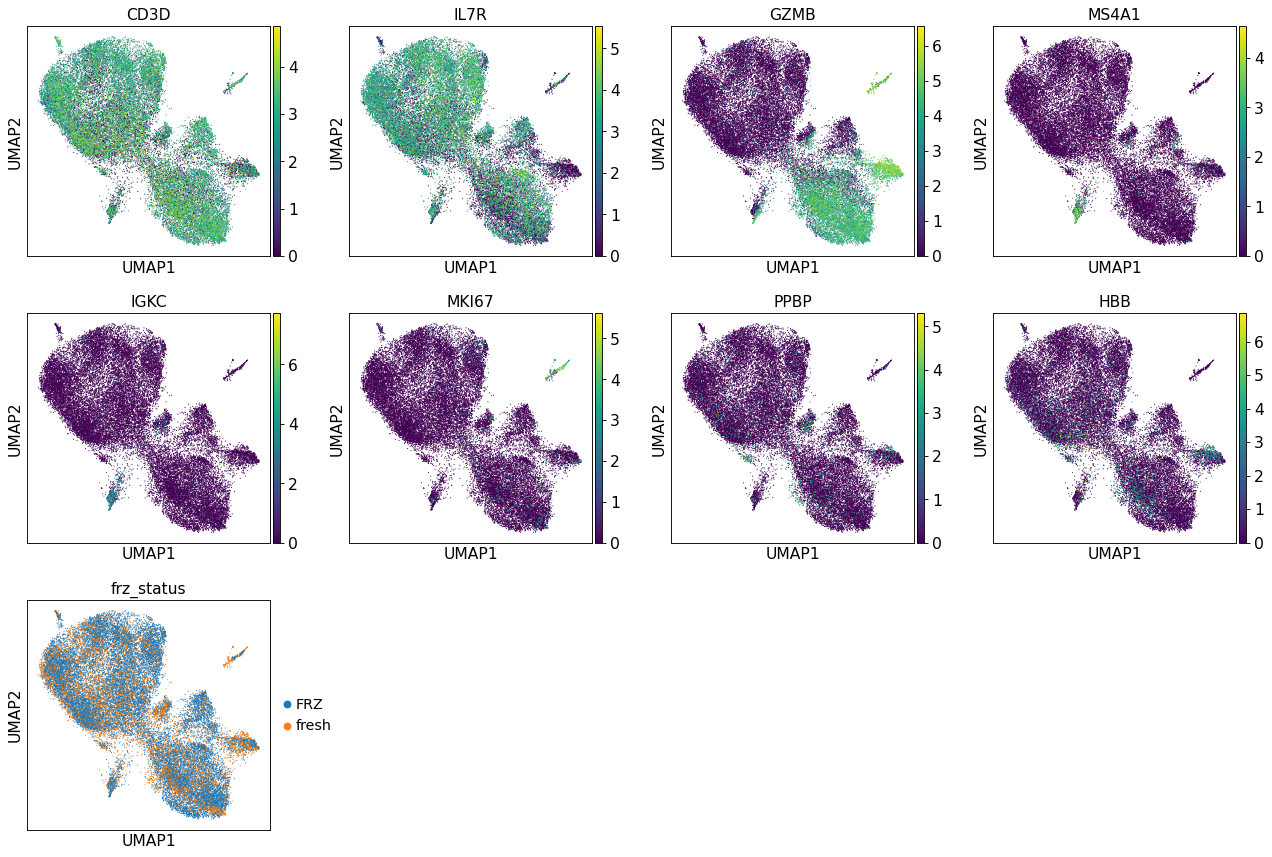

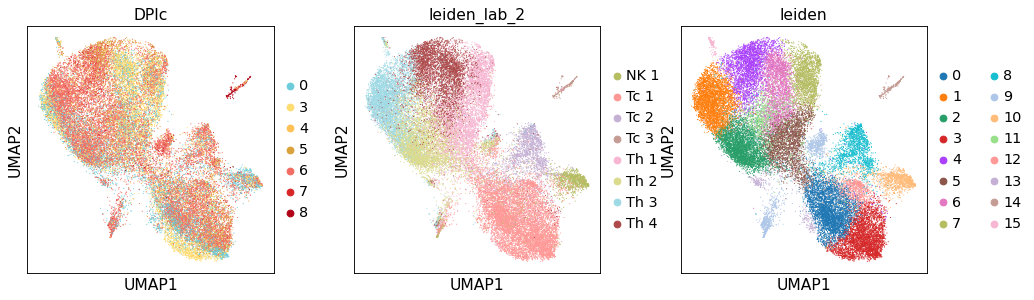

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:44)


0                   1                   2         3  \
0                 GZMB                SELL               RPS14      GZMB   
1             PPP1R12A                 CA6               RPS15      GZMH   
2                 GZMH              PECAM1              RPL10A    S100A4   
3               S100A4               RFLNB                RPS6  PPP1R12A   
4                 GNLY               PLAC8                RPL4     ITGB2   
5                ITGB2               ITGA6               RPL30     SYNE1   
6              S100A10              RPL10A  ENSMMUG00000002676      GNLY   
7                SYNE1                RPL4               RPL22   S100A10   
8   ENSMMUG00000014256                LEF1               RPL13     ITGAL   
9               TGFBR3                TCF7               RPS11    TGFBR3   
10                 ID2  ENSMMUG00000002676                RPS5      RGS9   
11                RGS9               RPL18                 CA6     RUNX3   
12  ENSMMUG00000038528               RPL30              RPL27A     AHNAK   
13  ENSMMUG00000048425                RPS3               RPL18       ID2   
14               AHNAK               RPL22              RPS27A     RAP1B   
15              NFKBIA                RPL8                RPS7      ZEB2   
16               ITGAL  ENSMMUG00000015270  ENSMMUG00000015270     ANXA1   
17               RUNX3               RPS4X              RPL13A     SYTL2   
18               PTPRC               RPS15               RPS16     PTPRC   
19               SYTL2  ENSMMUG00000003867               RPS23     ANXA2   

         4        5                   6        7                   8  \
0    SYNE2     TPT1               TRIB2    ITGB1  ENSMMUG00000038528   
1      MX1      FOS                 FOS      VIM               ITGAX   
2    DDX60      VIM              GPR183  S100A10  ENSMMUG00000042057   
3    TRIB2    RPS14                ICOS    ANXA2                GNLY   
4   RNF213   GPR183               EEF1G    DPEP2               IL2RB   
5   DDX60L    ITGB1              EEF1A1   GPR183               IFI44   
6   SMCHD1    RPS16               RACK1     RGS1               PLAC8   
7   EPSTI1  ZFP36L2               ZFP36    SYNE2                TCF7   
8    IFI16    RPL11              PTGER4     LMNA               SCML4   
9   SAMD9L   RPL13A              RPL10A  FAM107B               IFI27   
10   IFIH1    RACK1               RPS14   SAMSN1            HSP90AB1   
11     MX2     RPS5                RPL8  ZFP36L2                NME2   
12   SP100    RPS23                RPS3    ISG15                CTSW   
13   DDX58    RPS20                RPS5   PTGER4              SEPT11   
14    CHD2     RPS7  ENSMMUG00000003867  TNFSF10              PECAM1   
15   ISG15    RPS19              GPRIN3     IL7R               PRKCH   
16   IFI44   RPL27A                KLF6      MX1                COX2   
17   HERC6     RGS1               RPS16      DST              PTPN22   
18   RSAD2      UBC                TPT1      UBC               VEGFA   
19  ARID5B    RPLP0  ENSMMUG00000002676    LIMS1                GNAS   

                     9                  10      11                  12  \
0               S100A9                GNLY     MX1                GZMK   
1               S100A8                GZMB   ISG15               KLRB1   
2                MS4A1                GZMH   SYNE2              TGFBR3   
3                 IGKC               FCGR3   DDX60                IL7R   
4                 COX2               ITGB2  DDX60L              PIK3R1   
5             MAMU-DRA                HOPX     MX2                GNLY   
6                 IGHM                ACTB   RSAD2                CD69   
7                BANK1                GZMA   IFIH1                 ID2   
8               SWAP70               IL2RB    XAF1  ENSMMUG00000038528   
9             MAMU-DPA                JAK1   SP100              NFKBIA   
10                 MX1              TYROBP  SAMD9L            PPP1R12A   
11               IFI27 

In [13]:
adata_1 = subcluster_iteration(adata_raw,
                        min_cells=int(adata_raw.shape[0]*.001),
                        nhvgs=nhvgs, npcs=17,
                        n_neighbors=int(adata_raw.shape[0]*.001),
                        min_dist=0.1, spread=2.0,resolution=1.5,
                        umap_genestoplot=genestoplot, pc_genestoplot=['GZMB'],
                        other_plot=['DPIc', 'leiden_lab_2', 'leiden'],
                        harmony=True, harmony_theta=.5, scale=True)

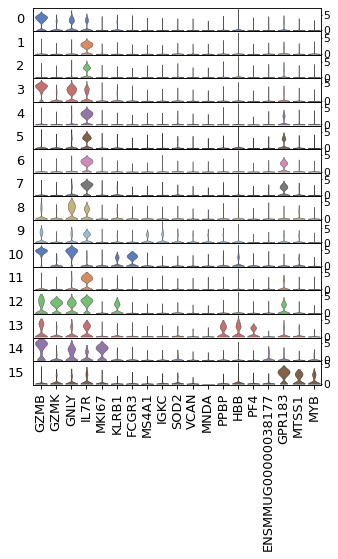

In [14]:
_ = sc.pl.stacked_violin(adata_1, var_names=['GZMB', 'GZMK','GNLY', 'IL7R', 'MKI67','KLRB1', 'FCGR3', 'MS4A1', 'IGKC', 'SOD2', 'VCAN', 'MNDA', 'PPBP', 'HBB', 'PF4', 'ENSMMUG00000038177', 'GPR183', 'MTSS1', 'MYB'], groupby='leiden')

In [18]:
## Harmony + baseline PCs
labmap = {'0':'Tc',
          '1':'Th',
          '2':'Th',
          '3':'Tc',
          '4':'Th',
          '5':'Th',
          '6':'Th',
          '7':'Th',
          '8':'Tc',
          '9':'Doublet',
          '10':'NK',
          '11':'Th',
          '12':'Tc',
          '13':'Doublet',
          '14':'Tc',
          '15':'Doublet'}

... storing 'leiden_lab' as categorical


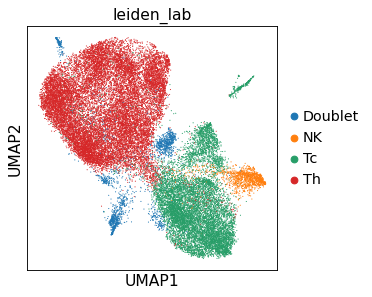

In [19]:
adata_1.obs['leiden_lab'] = adata_1.obs['leiden'].replace(labmap)
sc.pl.umap(adata_1, color='leiden_lab')

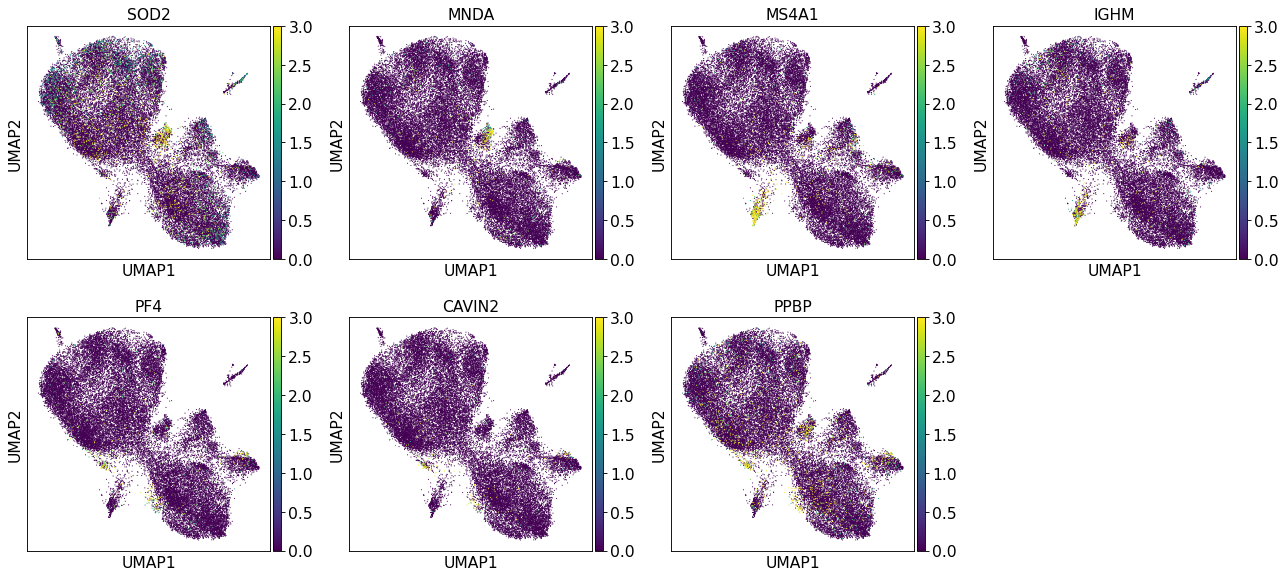

In [20]:
sc.pl.umap(adata_1, color=['SOD2', 'MNDA', 'MS4A1', 'IGHM', 'PF4', 'CAVIN2', 'PPBP'], vmax=3)

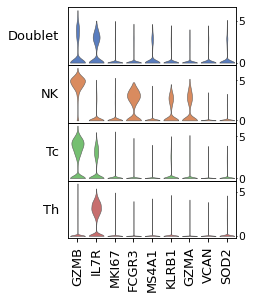

In [21]:
_ = sc.pl.stacked_violin(adata_1, var_names=['GZMB', 'IL7R', 'MKI67', 'FCGR3', 'MS4A1', 'KLRB1', 'GZMA', 'VCAN', 'SOD2'], groupby='leiden_lab')

In [22]:
expr = pd.DataFrame(adata_1.X, index=adata_1.obs.index, columns=adata_1.var.index)
cluster_mean = expr.groupby(adata_1.obs['leiden']).mean().T
cluster_mean['14'].sort_values(ascending=False).head(50)

index
GZMA                  2.087044
MCM10                 1.933114
MCM6                  1.928369
SERPINB1              1.842611
ENSMMUG00000017625    1.772828
FEN1                  1.751444
CENPU                 1.699408
IL2RA                 1.690193
HAVCR2                1.486272
CDCA7                 1.366932
ATAD2                 1.257770
GNA15                 1.182919
HELLS                 1.166010
ATAD5                 1.142276
ZGRF1                 1.141447
POLQ                  1.126044
TEDC2                 1.102240
BRCA1                 1.089911
FAM111B               1.081273
NDC80                 1.072575
ERCC6L                1.063684
SHMT1                 1.055930
POLA1                 0.996252
CDC45                 0.993623
GIMAP4                0.972672
SSRP1                 0.963521
DNMT1                 0.952803
CIP2A                 0.930441
FANCI                 0.920603
FANCD2                0.896060
ENSMMUG00000020275    0.870245
LIG1                  0.856645
CK

In [23]:
T_file_initial = results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyTNKIter1.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(T_file_initial)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyTNKIter1.h5ad


In [24]:
save_adata(adata_1, T_file_initial, gcs=gcs)

Only considering the two last: ['.OnlyTNKIter1', '.h5ad'].
Only considering the two last: ['.OnlyTNKIter1', '.h5ad'].


In [25]:
doublet_ind = adata_1.obs.index[adata_1.obs['leiden_lab'].isin(['Doublet'])]
adata_annot.obs.loc[doublet_ind, 'Doublet'] = True

<a id="cluster_T2"></a>
## Iterative subclustering 2 - classify cell types

In [26]:
genestoplot2 = ['CD3D', 'GNLY', 'GZMB', 'GZMK', 'GZMA', 'FCGR3', 'KLRB1', 'ITGB1', 'ITGB2', 'SELL', 'FOS', 'MKI67', 'frz_status']

In [27]:
cells_to_keep = adata_1.obs.index[~adata_1.obs['leiden_lab'].isin(['Doublet'])]
len(cells_to_keep)

29700

filtered out 211 genes that are detectedin less than 10 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)


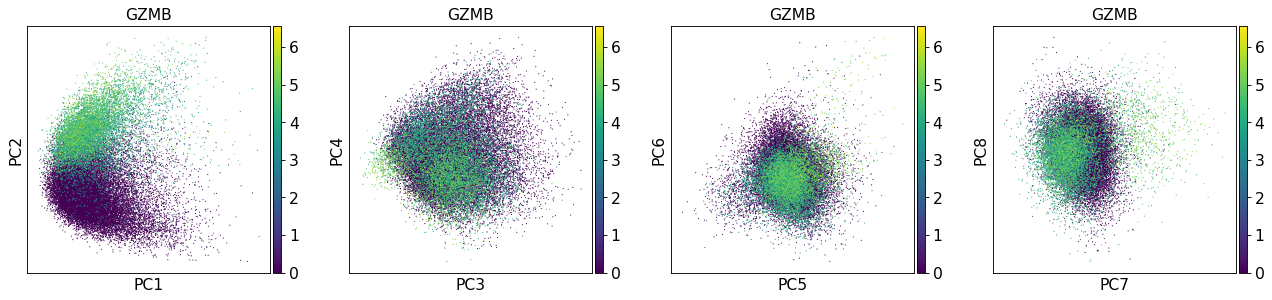

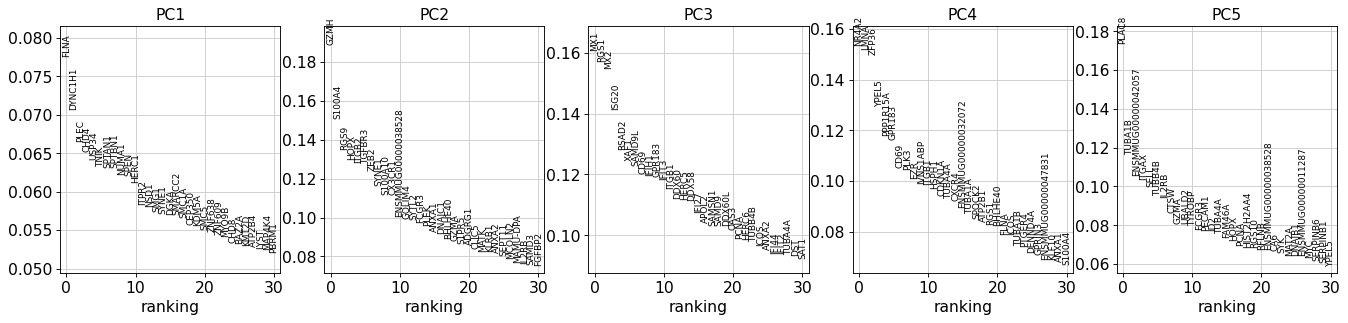

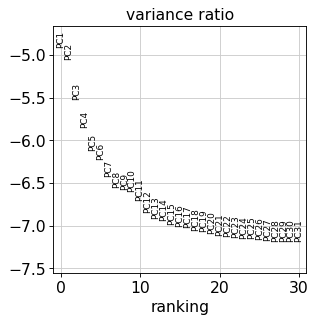

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:54)


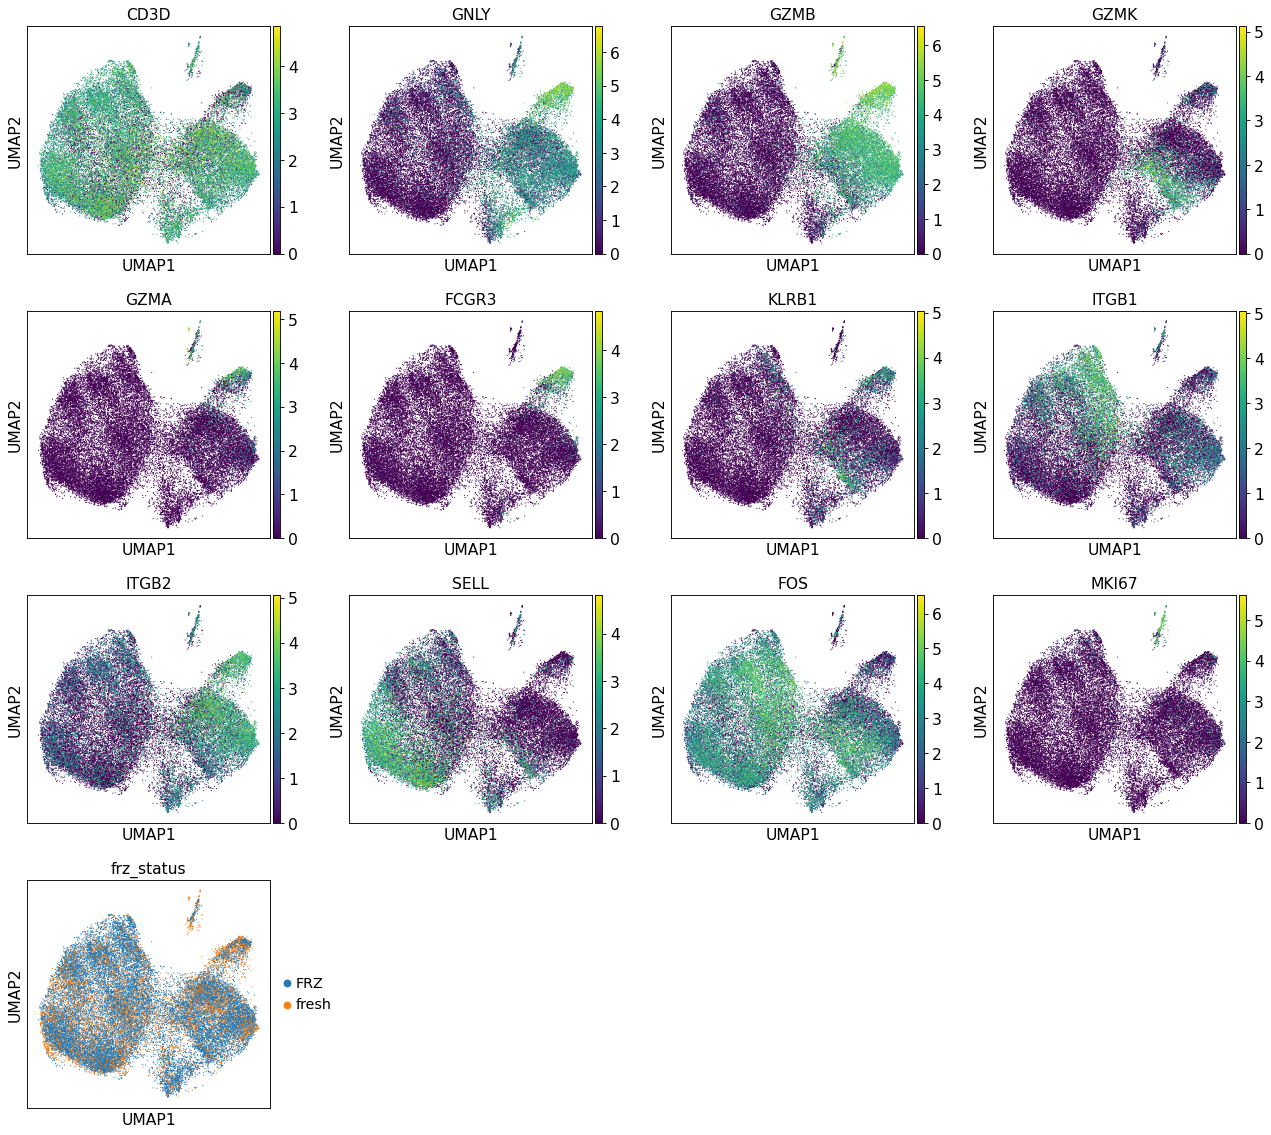

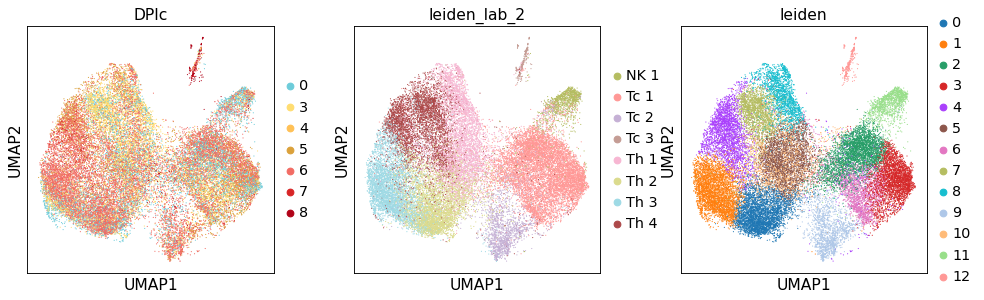

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:40)


0                   1                   2  \
0                RPS14                SELL                GZMB   
1               RPL10A                 CA6            PPP1R12A   
2                RPL30               RFLNB                GZMH   
3                 RPS6              PECAM1              S100A4   
4                RPS15               PLAC8               ITGB2   
5                RPS11               ITGA6             S100A10   
6                 RPL4              RPL10A                GNLY   
7                 RPS5                RPL4  ENSMMUG00000014256   
8               RPL27A  ENSMMUG00000002676               SYNE1   
9                RPL22                LEF1                RGS9   
10               RPL13               RPL30  ENSMMUG00000038528   
11  ENSMMUG00000002676                TCF7              TGFBR3   
12              RPS27A               RPL18                 ID2   
13               RPL18                RPS3  ENSMMUG00000048425   
14                 CA6               RPL22                ZEB2   
15              RPL13A                RPL8               RUNX3   
16               RPS16  ENSMMUG00000015270               ITGAL   
17  ENSMMUG00000015270  ENSMMUG00000003867               SYTL2   
18               RACK1               RPS15               AHNAK   
19                RPS7               RPL23               PTPRC   

                     3       4                   5                   6  \
0                 GZMB   SYNE2                 FOS                CD69   
1                 GZMH     MX1              GPR183                GZMK   
2             PPP1R12A   DDX60                TPT1              NFKBIA   
3               S100A4  RNF213               RPS14                KLF6   
4                SYNE1  SMCHD1               RPS16              TGFBR3   
5                ITGB2  DDX60L               ITGB1                GNLY   
6                 GNLY  EPSTI1                 VIM  ENSMMUG00000047461   
7                ITGAL   IFI16                RPS5                 ID2   
8              S100A10  PRRC2C               SYNE2                 FOS   
9                 RGS9   TRIB2             ZFP36L2               NR4A2   
10               SYTL2    CHD2               RPL11                RGS1   
11              TGFBR3   SP100               RACK1                GZMB   
12               APOL2   IFIH1              RPL13A               CXCR4   
13               RUNX3  SAMD9L                RPS7             S100A10   
14  ENSMMUG00000038528    UTRN               RPS23             BHLHE40   
15               AHNAK   DDX58               RPS20               YPEL5   
16                ZEB2     MX2               RPS19              S100A4   
17               RAP1B  SCAPER  ENSMMUG00000003867                 B2M   
18               ANXA1   HERC6              RPL27A             ZFP36L2   
19               ANXA2   IFI44               RPS15  ENSMMUG00000048425   

                     7        8                   9      10  \
0                TRIB2    ITGB1  ENSMMUG00000038528     MX1   
1               GPR183      VIM               ITGAX   ISG15   
2                  FOS    DPEP2  ENSMMUG00000042057   SYNE2   
3                EEF1G    ANXA2                GNLY     MX2   
4                 ICOS  S100A10               PLAC8  DDX60L   
5               EEF1A1   GPR183               IFI44   RSAD2   
6                ZFP36     RGS1               IL2RB   ISG20   
7                 RPS3    SYNE2                TCF7  GIMAP7   
8               PTGER4    ISG15               IFI27   DDX60   
9   ENSMMUG00000003867   SAMSN1               SCML4   IFI27   
10                KLF6  FAM107B                NME2    XAF1   
11               RPL10     LMNA                COX2   IFI44   
12               RACK1      MX1              PECAM1   IFIH1   
13              GPRIN3  TNFSF10                CTSW   SP100   
14                RPL8  ZFP36L2              SEPT11  SAMD9L   
15               RPS14   PTGER4            HSP90AB1    IL7R   
16      

In [39]:
adata_2 = subcluster_iteration(adata_raw[cells_to_keep,:], min_cells=10, nhvgs=nhvgs, npcs=15,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.5,
                        umap_genestoplot=genestoplot2, pc_genestoplot=['GZMB'],
                        other_plot=['DPIc', 'leiden_lab_2', 'leiden'],
                        harmony=True, harmony_theta=.5, scale=True)

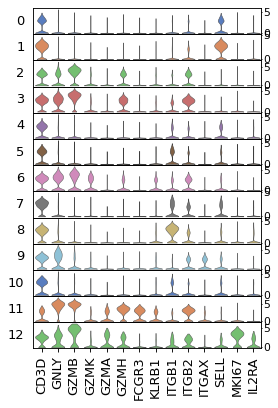

In [40]:
_ = sc.pl.stacked_violin(adata_2, var_names=['CD3D', 'GNLY', 'GZMB', 'GZMK','GZMA', 'GZMH', 'FCGR3', 'KLRB1',  'ITGB1', 'ITGB2', 'ITGAX', 'SELL', 'MKI67', 'IL2RA'], groupby='leiden')

In [41]:
vc = adata_2.obs['leiden'].value_counts()
vc.div(vc.sum())

0     0.121953
1     0.121582
2     0.115421
3     0.098350
4     0.097576
5     0.094209
6     0.068081
7     0.067306
8     0.060774
9     0.053906
10    0.048519
11    0.041886
12    0.010438
Name: leiden, dtype: float64

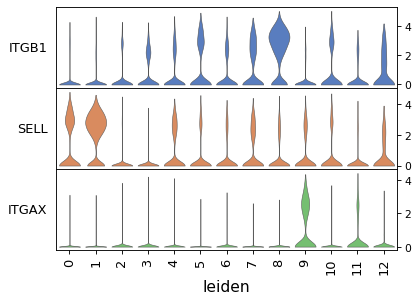

In [42]:
_ = sc.pl.stacked_violin(adata_2, var_names=[ 'ITGB1', 'SELL', 'ITGAX'], groupby='leiden', swap_axes=True, figsize=(6,4))

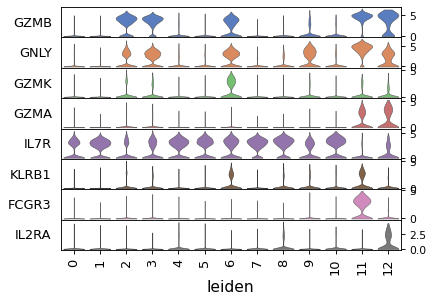

In [43]:
_ = sc.pl.stacked_violin(adata_2, var_names=[ 'GZMB', 'GNLY', 'GZMK','GZMA', 'IL7R', 'KLRB1', 'FCGR3', 'IL2RA'], groupby='leiden', swap_axes=True, figsize=(6,4))

In [44]:
labmap = {'0':'Th_ITGB1lo_SELLhi 1',
        '1':'Th_ITGB1lo_SELLhi 2',
        '2':'Tc 1',
        '3':'Tc 2',
        '4':'Th_ITGB1mid_SELLmid 1',
        '5':'Th_ITGB1mid_SELLmid 2',
        '6':'Tc_GZMKhi 1',
        '7':'Th_ITGB1mid_SELLmid 3',
        '8':'Th_ITGB1hi_SELLlo 1',
        '9':'Tc_ITGAXhi 1',
        '10':'Th_ITGB1mid_SELLmid 4', 
        '11':'NK 1',
        '12':'Tc_GZMAhi_MKI67hi 1',
         }

pd.Series(labmap).value_counts()

Tc 1                     1
NK 1                     1
Th_ITGB1mid_SELLmid 2    1
Th_ITGB1hi_SELLlo 1      1
Th_ITGB1mid_SELLmid 1    1
Th_ITGB1lo_SELLhi 1      1
Th_ITGB1mid_SELLmid 3    1
Th_ITGB1lo_SELLhi 2      1
Tc_GZMKhi 1              1
Tc_GZMAhi_MKI67hi 1      1
Tc 2                     1
Th_ITGB1mid_SELLmid 4    1
Tc_ITGAXhi 1             1
dtype: int64

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


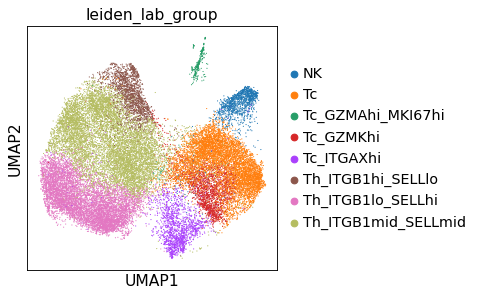

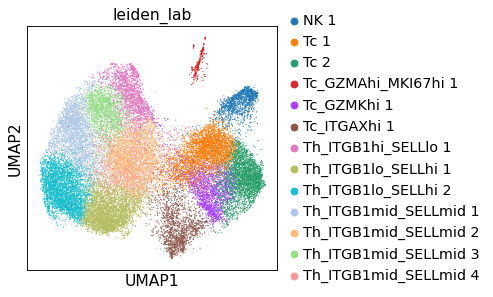

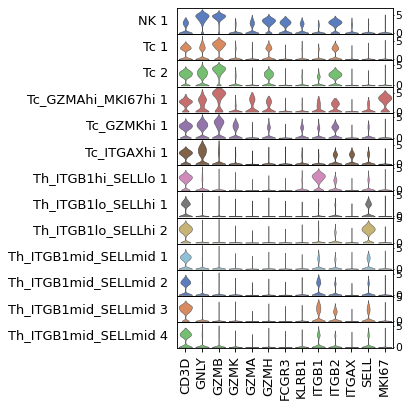

In [45]:
adata_2.obs['leiden_lab'] = adata_2.obs['leiden'].replace(labmap)
adata_2.obs['leiden_lab_group'] = adata_2.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

sc.pl.umap(adata_2, color=['leiden_lab_group'])
sc.pl.umap(adata_2, color=['leiden_lab'])

_ = sc.pl.stacked_violin(adata_2,
                         var_names=['CD3D', 'GNLY','GZMB', 'GZMK','GZMA', 'GZMH', 'FCGR3', 'KLRB1',  'ITGB1', 'ITGB2', 'ITGAX', 'SELL', 'MKI67'],
                         groupby='leiden_lab')

In [46]:
adata_2.obs['leiden_lab_group'].value_counts()

Th_ITGB1mid_SELLmid    9136
Th_ITGB1lo_SELLhi      7233
Tc                     6349
Tc_GZMKhi              2022
Th_ITGB1hi_SELLlo      1805
Tc_ITGAXhi             1601
NK                     1244
Tc_GZMAhi_MKI67hi       310
Name: leiden_lab_group, dtype: int64

In [47]:
adata_annot.obs['Subclustering'] = adata_annot.obs['Subclustering'].astype(str)
adata_annot.obs['SubclusteringGroup'] = adata_annot.obs['SubclusteringGroup'].astype(str)
adata_annot.obs.loc[adata_2.obs.index, 'SubclusteringGroup'] = adata_2.obs['leiden_lab_group']
adata_annot.obs.loc[adata_2.obs.index, 'Subclustering'] = adata_2.obs['leiden_lab']

In [48]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMBTNK.h5ad


In [49]:
save_adata(adata_annot, results_file, gcs=gcs)

Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].
Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].


... storing 'SubclusteringGroup' as categorical
... storing 'Subclustering' as categorical


In [6]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyTNK.h5ad


In [51]:
save_adata(adata_2, results_file_sub, gcs=gcs)

Only considering the two last: ['.OnlyTNK', '.h5ad'].
Only considering the two last: ['.OnlyTNK', '.h5ad'].


In [52]:
pd.crosstab([adata_annot.obs['leiden_lab_group_2'], adata_annot.obs['Doublet']], adata_annot.obs['SubclusteringGroup'])

SubclusteringGroup          B_Memory  B_Memory_SELL+  B_Naive  Mono   NK  \
leiden_lab_group_2 Doublet                                                 
B                  False       10908             640     1936     0    0   
                   True            0               0        0     0    0   
Mono/DC            False           0               0        0  6958    0   
                   True            0               0        0     0    0   
NK                 False           0               0        0     0  959   
                   True            0               0        0     0    0   
Neut               False           0               0        0    12    0   
                   True            0               0        0     0    0   
Plasmablast        False          19               1        1     0    0   
                   True            0               0        0     0    0   
Platelet           False           0               0        0     6    0   
                   True            0               0        0     0    0   
Tc                 False           0               0        0     0  278   
                   True            0               0        0     0    0   
Th                 False           0               0        0     0    7   
                   True            0               0        0     0    0   

SubclusteringGroup          Neut  Plasmablast    Tc  Tc_GZMAhi_MKI67hi  \
leiden_lab_group_2 Doublet                                               
B                  False       0           90     0                  0   
                   True        0            0     0                  0   
Mono/DC            False      47            0     0                  0   
                   True        0            0     0                  0   
NK                 False       0            0   114                  5   
                   True        0            0     0                  0   
Neut               False    5756            0     0                  0   
                   True        0            0     0                  0   
Plasmablast        False       0          176     0                  0   
                   True        0            0     0                  0   
Platelet           False       2            0     0                  0   
                   True        0            0     0                  0   
Tc                 False       0            0  6021                273   
                   True        0            0     0                  0   
Th                 False       0            0   214                 32   
                   True        0            0     0                  0   

SubclusteringGroup          Tc_GZMKhi  Tc_ITGAXhi  Th_ITGB1hi_SELLlo  \
leiden_lab_group_2 Doublet                                             
B                  False            0           0                  0   
                   True             0           0                  0   
Mono/DC            False            0           0                  0   
                   True             0           0                  0   
NK                 False            4          10                  0   
                   True             0           0                  0   
Neut               False            0           0                  0   
                   True             0           0                  0   
Plasmablast        False            0           0                  0   
                   True             0           0                  0   
Platelet           False            0           0                  0   
                   True             0           0                  0   
Tc                 False         1848        1442                 39   
                   True             0           0                  0   
Th                 False          170         149               1766   
                   True             0           0                  0   

S

<a id="figuresM"></a>
## Output figures

In [6]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))

print(annot_file)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMB.h5ad


In [7]:
adata_annot = read_adata(annot_file, gcs=gcs)

Only considering the two last: ['.SubclusterMB', '.h5ad'].
Only considering the two last: ['.SubclusterMB', '.h5ad'].


In [8]:
## Reprocess because we want to show MKI67 which was being left out due to being a cell cycle gene
adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group_2'].isin(['Th', 'Tc', 'NK']), :]

ind = ~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])
ind = ind | (adata_raw.var.index=='MKI67')

adata_raw = adata_raw[:,ind]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

filtered out 2264 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [9]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyTNK.h5ad


In [10]:
adata_2 = read_adata(results_file_sub, gcs=gcs)

Only considering the two last: ['.OnlyTNK', '.h5ad'].
Only considering the two last: ['.OnlyTNK', '.h5ad'].


In [11]:
expression_full = pd.DataFrame(adata_raw[adata_2.obs.index,:].X.todense(), index=adata_2.obs.index, columns=adata_raw.var.index)

In [12]:
list(adata_2.obs['leiden_lab_group'].unique())

['Th_ITGB1mid_SELLmid',
 'Tc_GZMKhi',
 'NK',
 'Tc',
 'Th_ITGB1lo_SELLhi',
 'Th_ITGB1hi_SELLlo',
 'Tc_ITGAXhi',
 'Tc_GZMAhi_MKI67hi']

In [13]:
genes_to_plot = ['CD3D', 'IL7R', 'ITGB1', 'SELL', 'GNLY', 'GZMB', 'GZMK', 'GZMA', 'MKI67', 'FCGR3', 'KLRB1']
celltype_order = [
    
 'Th_ITGB1lo_SELLhi',    
'Th_ITGB1mid_SELLmid',
 'Th_ITGB1hi_SELLlo',
 'Tc',
 'Tc_ITGAXhi',
 'Tc_GZMKhi',
 'Tc_GZMAhi_MKI67hi',
 'NK',
]

celltype_order_clean = [x.replace('_', ' ').replace('Th', 'T CD4+').replace('Tc', 'T CD8+') for x in celltype_order]


adata_2.obs['Grouped_Clustering'] = pd.Categorical(adata_2.obs['leiden_lab_group'].apply(lambda x: x.replace('_', ' ').replace('Th', 'T CD4+').replace('Tc', 'T CD8+')).values,
                                                                                         categories=celltype_order_clean)



expression = expression_full.loc[:, genes_to_plot]
obs = adata_2.obs.copy()
obs['UMAP_1'] = adata_2.obsm['X_umap'][:,0]
obs['UMAP_2'] = adata_2.obsm['X_umap'][:,1]

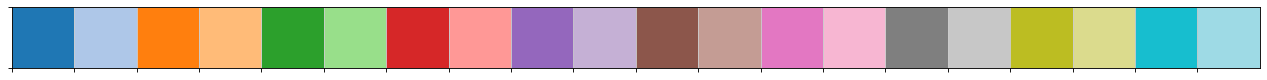

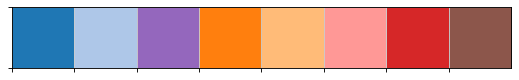

In [14]:
allcolors = palettable.tableau.Tableau_20.hex_colors
sns.palplot(allcolors)

ctcolors = [allcolors[0], allcolors[1], allcolors[8], allcolors[2], allcolors[3],allcolors[7], allcolors[6], allcolors[10]]
sns.palplot(ctcolors)

ctmap = dict(zip(celltype_order_clean, ctcolors))
obs['ctcolor'] = obs['Grouped_Clustering'].replace(ctmap)


In [15]:
from matplotlib import gridspec
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

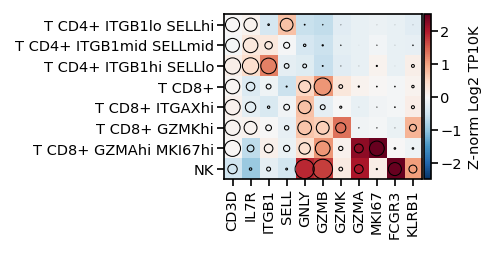

In [50]:
percent_positive = expression.groupby(obs['Grouped_Clustering']).agg(lambda x: (x>0).mean())

expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(adata_2.obs['Grouped_Clustering']).mean()

width=3.15
heatmap_width=2.1
legend_width=.6
left_space=.45

heatmap_height = 1.1
bottom_space = .42
top_space = .13
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

alldotsize = percent_positive.copy()
alldotsize = alldotsize - alldotsize.min().min()
alldotsize = alldotsize / alldotsize.max().max()
alldotsize = (alldotsize * 9.4) ** 2

allcolors = average_expression.copy()
vmin=-2.5
vmax=2.5
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order_clean, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order_clean)))
heatmap_ax.set_yticklabels(celltype_order_clean)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)
#heatmap_ax.set_title('T/NK - Seq-Well', pad=0)

for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order_clean):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)

        
        
        

plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 9.4) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .2

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.45, .82, 5)


size_legend_ax.text(.7, .5, 'Z-norm Log2 TP10K', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)

'''
sizelegendfontsize = 7
size_legend_ax.scatter(leg_x, leg_y, s=leg_dot_size, edgecolor='k',  linewidth=.5, c='.8')
for i in range(5):
    size_legend_ax.text(leg_x[i]+text_offset, leg_y[i], ('%d' % (100*vals[i])) + '%', fontsize=sizelegendfontsize, va='center')
size_legend_ax.text(.42, 1.05, '% Cells with\ngene detected', ha='center', va='top', fontsize=sizelegendfontsize)
    
heatmap_ax.hlines(y=2.5, xmin=-.5, xmax=len(genes_to_plot)-.5, linestyle='--', color='k')
heatmap_ax.hlines(y=6.5, xmin=-.5, xmax=len(genes_to_plot)-.5, linestyle='--', color='k')

heatmap_ax.vlines(x=3.5, ymin=-.5, ymax=len(celltype_order_clean)-.5, linestyle='--', color='k')
heatmap_ax.vlines(x=8.5, ymin=-.5, ymax=len(celltype_order_clean)-.5, linestyle='--', color='k')
'''

figure_file = os.path.join(results_dir, "Subcluster.TNK.Seqwell.Invivo.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


In [47]:
box_height=1.5
box_width=1.5
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.5
valdpi = 200

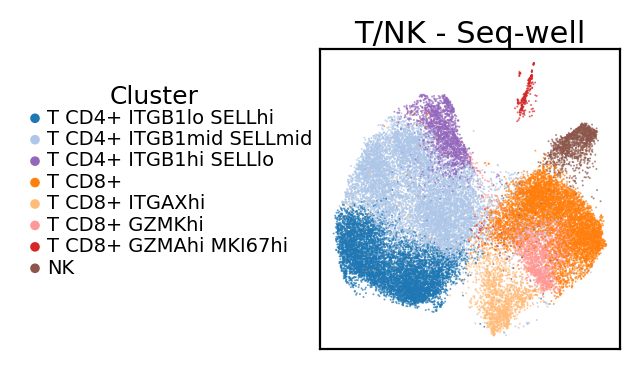

In [49]:
leg_width=1.5
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(leg_width, box_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(obs['UMAP_1'], obs['UMAP_2'], c=obs['ctcolor'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

marker_x=.05
N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.77, .27, num=N)):
    ct = celltype_order_clean[i]
    legend_ax.scatter(marker_x, y, color=ctmap[ct], s=12, edgecolor='None')
    legend_ax.text(marker_x+.04, y-.015, ct, fontsize=7)
legend_ax.text(.3, .82, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'T/NK - Seq-well', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "Subcluster.UMAP.TNK.Seqwell.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)

## Check clonotype

In [7]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyTNK.h5ad


In [8]:
adata_2 = read_adata(results_file_sub, gcs=False)

Only considering the two last: ['.OnlyTNK', '.h5ad'].
Only considering the two last: ['.OnlyTNK', '.h5ad'].


In [38]:
vid = pd.read_csv('../../../../../data/misc/TRB_Vgene_toEnsemblID_Mapping.txt', sep='\t', index_col=0)
vid.index = vid['gn']
mapping = adata_2.raw.var.loc[adata_2.raw.var['full_id'].isin(vid['gn']),:]
mapping.index = mapping['full_id']
vid = vid.loc[mapping.index, :]
vid['matchsym'] = mapping.loc[vid.index,'gene_symbol']

In [21]:
expr = pd.DataFrame(adata_2.raw.X.todense(), index=adata_2.obs.index, columns=adata_2.raw.var.index)

In [40]:
expr = expr.loc[:, vid['matchsym']]

In [44]:
expr.columns = vid['VgeneID']

In [50]:
ind = adata_2.obs['leiden_lab_group'].isin(['Th_ITGB1mid_SELLmid', 'Tc_GZMKhi', 'Tc', 'Th_ITGB1lo_SELLhi', 'Th_ITGB1hi_SELLlo', 'Tc_ITGAXhi', 'Tc_GZMAhi_MKI67hi'])
obs = adata_2.obs.loc[ind, :]
expr = expr.loc[ind, :]

In [54]:
ind2 = expr.max(axis=1)>0

In [55]:
expr = expr.loc[ind2, :]

In [56]:
obs = obs.loc[ind2, :]

In [59]:
obs['Max_V_Usage'] = expr.idxmax(axis=1)

In [69]:
v_assign_count = obs.groupby(['animal', 'DPI', 'Max_V_Usage']).count().dropna().iloc[:,0].reset_index().rename(columns={'batch':'count'})
v_assign_count.pivot_table(index=('animal', 'DPI'), columns='Max_V_Usage', values='count').replace(np.nan, 0)

Max_V_Usage  TRBV10-2  TRBV15  TRBV16  TRBV19  TRBV2-1  TRBV2-2  TRBV2-3  \
animal DPI                                                                 
NHP08  -4         0.0     0.0     0.0     0.0      2.0      0.0      2.0   
        6         0.0     0.0     0.0     1.0      0.0      0.0      0.0   
NHP09  -4         4.0     0.0     0.0     2.0      0.0      0.0      0.0   
        8         1.0     0.0     0.0     0.0      0.0      1.0      0.0   
NHP10  -4         1.0     1.0     0.0     4.0      1.0     24.0      0.0   
        7         0.0     0.0     0.0     0.0      0.0      2.0      0.0   
NHP11  -4         3.0     0.0     0.0     0.0      0.0      0.0      0.0   
        6         0.0     0.0     0.0     0.0      0.0      0.0      0.0   
NHP12   8         0.0     0.0     0.0     0.0      0.0      0.0      1.0   
NHP13   0         0.0     1.0     0.0     0.0      0.0      0.0      0.0   
        3         2.0     1.0     1.0     2.0      1.0      0.0      0.0   
NHP14   0         0.0     1.0     1.0     0.0      0.0      1.0      1.0   
        3         9.0     6.0    10.0     5.0      5.0      2.0      6.0   
NHP15   0         1.0     0.0     0.0     1.0      0.0      3.0      3.0   
        3         0.0     2.0     2.0     2.0      0.0      1.0      4.0   
NHP16   0         1.0     1.0     0.0     0.0      0.0      0.0      0.0   
        5        22.0     1.0     4.0     2.0      0.0      1.0      6.0   
NHP17   0         0.0     0.0     0.0     0.0      0.0      0.0      1.0   
        5         3.0     0.0     0.0     1.0      0.0      0.0      1.0   
NHP18   0         0.0     0.0     0.0     0.0      0.0      0.0      0.0   
        5         1.0     0.0     0.0     1.0      0.0      0.0      0.0   
NHP19   4         0.0     0.0     1.0     0.0      1.0      1.0      2.0   
NHP20  -30        3.0     1.0     0.0     2.0      2.0      0.0      0.0   
NHP22   6         1.0     1.0     1.0     1.0      6.0      0.0      2.0   
NHP23  -30        0.0     0.0     0.0     0.0      0.0      0.0      1.0   
        6         2.0     1.0     4.0     3.0      5.0      3.0      4.0   
NHP24   6         6.0     0.0     4.0     1.0      0.0      1.0      3.0   
NHPC1   0         0.0     0.0     0.0     0.0      0.0      0.0      0.0   

Max_V_Usage  TRBV21-1  TRBV23-1  TRBV24-1  TRBV27  TRBV29-1  TRBV4-1  TRBV4-2  \
animal DPI                                                                      
NHP08  -4         0.0       1.0       2.0     2.0       4.0      0.0      0.0   
        6         0.0       1.0       0.0     2.0       1.0      0.0      0.0   
NHP09  -4         0.0       3.0       0.0     2.0       2.0      0.0      0.0   
        8         0.0       0.0       0.0     0.0       0.0      0.0      0.0   
NHP10  -4         2.0       3.0       1.0     2.0       6.0      1.0      5.0   
        7         1.0       6.0       0.0     0.0       0.0      0.0      0.0   
NHP11  -4         0.0       8.0       0.0     3.0       2.0      0.0      0.0   
        6         0.0       1.0       0.0     1.0       0.0      0.0      0.0   
NHP12   8         0.0       0.0       2.0     2.0       0.0      4.0      2.0   
NHP13   0         0.0       3.0       2.0     1.0       2.0      0.0      1.0   
        3         1.0       5.0      18.0     1.0       2.0      2.0      1.0   
NHP14   0         0.0       0.0       7.0     0.0       0.0      1.0      0.0   
        3         1.0      12.0      25.0     8.0      26.0      9.0      1.0   
NHP15   0         1.0       6.0       0.0     1.0       2.0      1.0      1.0   
        3         1.0      11.0      25.0     5.0       2.0      2.0      3.0   
NHP16   0         0.0       1.0       0.0     0.0       0.0      0.0      0.0   
        5         2.0      10.0      30.0    12.0      24.0      4.0      2.0   
NHP17   0         0.0       0.0       0.0     0.0       0.0      0.0      0.0   
        5         1.0       0.0       0.0     1.0       0.0      0.0      0.0   
NHP18   0         